# 1. 

**Usando K-Means y el datasetblow.csv desarrolla.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d

Primero definimos una función para procesar el dataset propuesto.

In [107]:
def load_dataset(file, plot= False):
  '''Carga un data set con puntos para K-means

  returns:
    - np.array con los puntos obtenidos
    - coordenadas x, y
  '''
  data = pd.read_csv(file, index_col= 0)                # Lee el archivo csv
  data_x, data_y = data['0'], data['1']                 # Separa las coordenadas del punto
  dataset_points = np.array(list(zip(data_x, data_y)))  # Agrupa las coordenadas como un `np.array` de puntos
  
  # Grafica los puntos obtenidos
  if plot:
    fig, ax = plt.subplots()
    ax.scatter(data_x, data_y)

  return dataset_points, data_x, data_y

Vizualizamos los datos obtenidos.

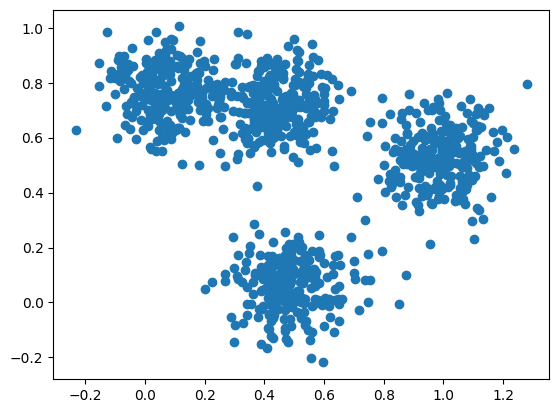

In [108]:
points, x, y = load_dataset('datablow.csv', plot= True)

#### **(a)** Para $k = 2,\ ...\, 16$. Calcula el $WCSS$ para cada $k$ y gráfica los $WCSS$ de cada $k$ en una gráfica de lineas.
$$
  WCSS = \sum_{P_i \in Cluster_1}distance(P_i,\ C1)^2\ + \sum_{P_i \in Cluster_2}distance(P_i,\ C2)^2\ + ⋯ + \sum_{P_i \in Cluster_l}distance(P_i,\ Cl)^2
$$

Tenemos la siguiente implementación del algoritmo _K-means_ que está basada en la implementación vista en clase.

In [109]:
def euclidean_distance(p1, p2):
   '''Calcula la distancia euclideana
   '''
   return np.linalg.norm(p1 - p2)


def assign_points_to_cluster(points, cluster_center_points):
    '''Asigna los puntos a los clusters  
    
    Args:
      points    (`np.array`): Los puntos (x, y)  
      centroids (`np.array`): Los centroides (x,y)

    Returns:
      (`list`, `np.array`): la asignacion correspondiente de cada punto a su cluster
    '''
    cluster_point_lists = [[] for _ in range(len(cluster_center_points))]
    points_cluster_indexes = np.zeros(len(points), dtype=int)
    
    for i, p in enumerate(points):
        closest_cluster_index = np.argmin(
            [euclidean_distance(p, c) for c in cluster_center_points], axis=0
        )
        points_cluster_indexes[i] = closest_cluster_index
        cluster_point_lists[closest_cluster_index].append(p)
    
    return list(map(np.array, cluster_point_lists)), points_cluster_indexes


def k_means(num_clusters, points, seed=0):
    '''Ejecuta el algoritmo **K-means**  

    Args:
      k (int): El numero de clusters  
      points (`np.array`): Los puntos

    Returns:
      centroids        (`np.array`): Los centroides de cada cluster
      cluster_points_lists (`list`): Los puntos por cluster
      wcss     (float): El valor de **within-cluster sum of the square**
      frobenius (list): El valor del calculo de la Norma de Frobenius para cada iteracion
    '''
    rng = np.random.default_rng(seed=seed)

    # Se inicializan los centros aleatoriamente
    centroids = points[
        rng.choice(points.shape[0], num_clusters, replace=False), :
    ]

    frobenius = []  # Lista para ir almacenando los valores de la Norma de Frobenius

    # Se actualizan en un ciclo hasta que convergen
    points_cluster_indexes = points_cluster_indexes_prev = None
    converged = False
    while not converged:
        # Se asigna cada punto a un cluster
        cluster_point_lists, points_cluster_indexes = assign_points_to_cluster(
            points, centroids
        )

        # Guardamos una copia de los centroides (para Frobenius)
        cent_copy = centroids.copy()
        
        # Se calculan los nuevos centros
        for i in range(num_clusters):
            centroids[i] = np.mean(cluster_point_lists[i], axis= 0)

        # Calculamos la Norma de Frobenius y guardamos en la lista
        frobenius_norm = np.linalg.norm(cent_copy - np.array(centroids))
        frobenius.append(frobenius_norm)

        # Se revisa si hubo cambios en los centros
        if (points_cluster_indexes is not None) and np.array_equal(
            points_cluster_indexes, points_cluster_indexes_prev
        ):
            converged = True
        else:
            points_cluster_indexes_prev = points_cluster_indexes

    # Calculamos el WCSS
    wcss = 0.0
    for i in range(num_clusters):
        cluster_points = cluster_point_lists[i]
        cluster_center = np.mean(cluster_points, axis= 0)
        wcss += np.sum(np.square(np.linalg.norm(cluster_points - cluster_center, axis=1)))

    return centroids, cluster_point_lists, wcss, frobenius

Ahora ejecutamos `k_means` para $k = 1,\ ...,\ 16$ y vamos guardando el valor de $WCSS$ para cada uno.

In [110]:
wcss = []
for i in range(1, 17):
  K = i
  _, _, within_cluster_ss, _ = k_means(K, points)
  wcss.append(within_cluster_ss)

Con el arreglo obtenido, graficamos.

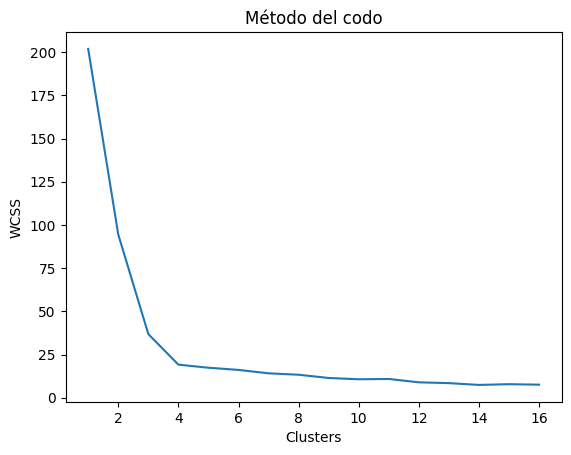

In [111]:
plt.plot(range(1, 17), wcss)
plt.title('Método del codo')
plt.xlabel('Clusters')
plt.ylabel('WCSS')      #within cluster sum of squares
plt.show()

#### **(b)** Usando la gráfica anterior justifica que valor de k sería "óptimo"  el criterio del "codo" y gráfica su Diagrama de Voronoid Generado por los centroides de dicho $k$.

De la gráfica obtenida en el punto anterior, vemos que el valor "óptimo" para $k$ es 4. 

Ahora, el código para obtener el diagrama de Voronoi generado por los centroides se presenta a continuación:

In [112]:
color_series = [("#F2D7D5", "#C0392B"), ("#EBDEF0", "#9B59B6"), ("#D4E6F1", "#2980B9"), ('#a7bca7', '#4f7a4e')]


def plot_clustering_results(cluster_centers, cluster_points_lists, padding):
    # Se genera diagrama de voronoi
    voronoi = Voronoi(cluster_centers)

    # Se crean vectores por coordenadas con los puntos de los clusters
    cluster_points_x = [[] for _ in range(len(cluster_centers))]
    cluster_points_y = [[] for _ in range(len(cluster_centers))]
    for i, cpl in enumerate(cluster_points_lists):
        cluster_points_x[i] += [p[0] for p in cpl]
        cluster_points_y[i] += [p[1] for p in cpl]

    # Se calculan los límites de la imagen
    min_x = min([min(c) for c in cluster_points_x])
    max_x = max([max(c) for c in cluster_points_x])
    min_y = min([min(c) for c in cluster_points_y])
    max_y = max([max(c) for c in cluster_points_y])

    # Se crean una figura y unos ejes para graficar
    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8.5)

    # Se grafica cada cluster
    for i, c in enumerate(cluster_centers):
        ax.scatter(
            cluster_points_x[i],
            cluster_points_y[i],
            #label=f"Cluster {i} points",
            c=color_series[i % len(color_series)][0],
        )

        ax.scatter(
            c[0],
            c[1],
            label=f"Cluster {i + 1} centroide",
            c=color_series[i % len(color_series)][1],
        )

    # Se grafican las fronteras del diagrama de voronoi
    voronoi_plot_2d(voronoi, ax, show_vertices=False, show_points=False)
    ax.set_xlim(min_x - padding, max_x + padding)
    ax.set_ylim(min_y - padding, max_y + padding)

    ax.legend()

    return fig, ax

Una vez deinido lo anterior, ejecutamos `k_means` para $k = 4$, obtenemos los puntos de los centroides y los pasamos como argumentos a la función. Entonces, tenemos que el Diagrama de Voronoi queda como sigue:


(<Figure size 1100x850 with 1 Axes>, <Axes: >)

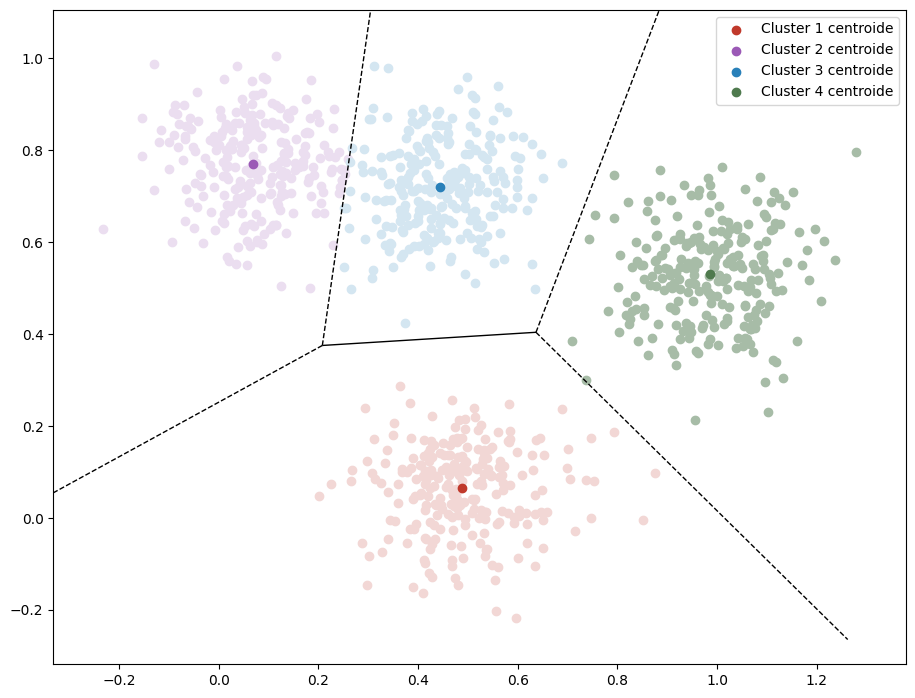

In [113]:
centroids, points_lists, _, frobenius = k_means(4, points)
plot_clustering_results(centroids, points_lists, padding=.1)

#### **(c)** Gráfica el comportamiento de la tolerancia relativa, i.e., la _Norma de Frobenius_ de la diferencia de los centroides como matriz para cada iteración.

Como en cada iteración del algoritmo vamos calculando la _Norma de Frobenius_ y al final de la ejecución quedamos con un arreglo que contiene todos los resultados, entonces nada más hace falta graficarlo para observar el comportamiento en cada iteración.  

A continuación se presenta la gráfica obtenida:

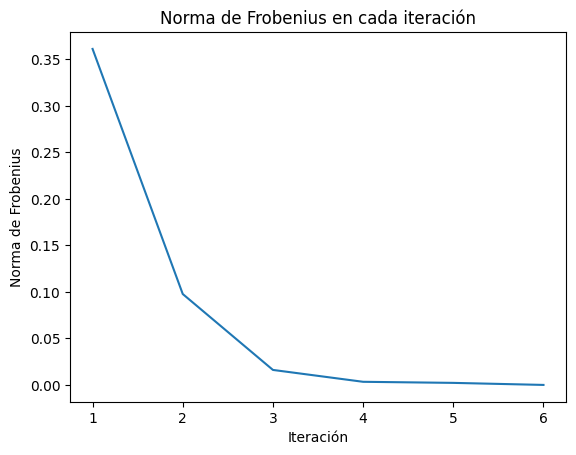

[0.36128252957481444, 0.0977414325622252, 0.01611991603002593, 0.0033568410114583882, 0.002197537832107145, 0.0]


In [114]:
plt.plot(range(1, len(frobenius) + 1), frobenius)
plt.title('Norma de Frobenius en cada iteración')
plt.xlabel('Iteración')
plt.ylabel('Norma de Frobenius')
plt.show()

print(frobenius)